In [2]:
import numpy as np
from matplotlib import pyplot as plt

import os
import pickle
from time import time
from sklearn.decomposition import PCA

import george
from george import kernels
from scipy.optimize import minimize

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

import lhsmdu

%matplotlib inline

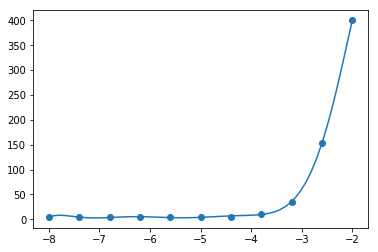

In [3]:
w0=[-25.707735, -25.710188, -25.709892, -25.706526, -25.693748, -25.55207, -24.482933, -18.821348, \
    5.002062, 123.48782, 370.23325]
logM_env=np.linspace(-8,-2,11)
p=np.flip(np.polyfit(logM_env,w0,8))

def polyout(x):
    out=30
    for i in range(len(p)):
        out+=p[i]*(x**i)
    return out

plt.scatter(logM_env,w0+30*np.ones(11))
x=np.linspace(-8,-2,60)
plt.plot(x,polyout(x))
plt.show()

In [4]:
#r=[[-8,-2],[-8,-2]]
#x=np.array(lhsmdu.sample(2,80))
#x=x*np.array([r[0][1]-r[0][0],r[1][1]-r[1][0]])[:,np.newaxis]
#x+=np.array([r[0][0],r[1][0]])[:,np.newaxis]

#with open('../grid_metadata/logmenvpoly_coords.txt', 'wb') as fp:
#    pickle.dump(np.transpose(x), fp)

with open ('../grid_metadata/logmenvpoly_coords.txt', 'rb') as fp:
    x = pickle.load(fp)

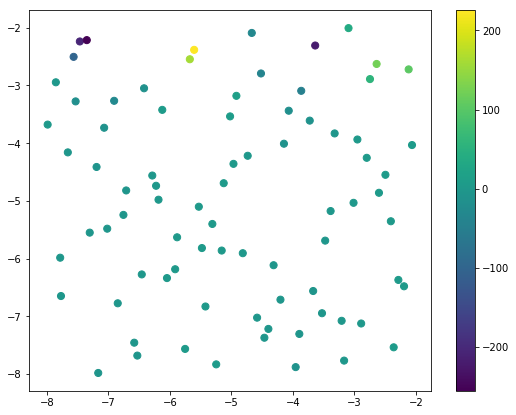

Initial ln-likelihood: -405.43
[ 7.46490668 -2.40794561  0.69314718]
[41.78148663  0.3         1.41421356]


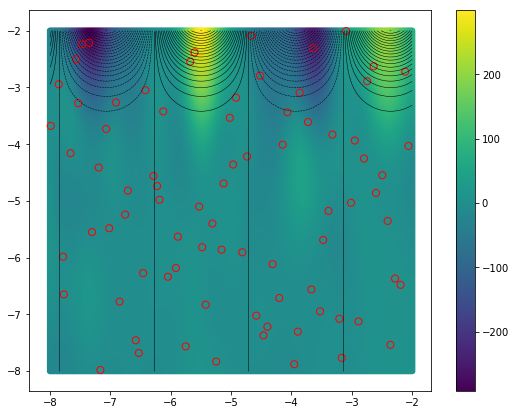

In [16]:
np.random.seed(250)
yerr=0.1*np.ones_like(x[:,0])
y=np.sin(2*x[:,0])*polyout(x[:,1]) + yerr*np.random.randn(len(x))

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(y), vmax=np.max(y))
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
plt.colorbar()
plt.show()

#kernel = np.var(y) * kernels.ExpSquaredKernel(0.3**2,ndim=2,axes=0)* kernels.PolynomialKernel(1.7,15,ndim=2,axes=1)
kernel = np.var(y) * kernels.ExpSquaredKernel(0.3**2,ndim=2,axes=0)* kernels.ExpSquaredKernel(2,ndim=2,axes=1)
gp = george.GP(kernel)
gp.compute(x,yerr)

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

x0pred,x1pred=np.meshgrid(np.linspace(-8, -2, 200),np.linspace(-8, -2, 200))
x_pred=list(map(lambda x, y:(x,y), np.ndarray.flatten(x0pred), np.ndarray.flatten(x1pred)))
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize=(9,7))
style = dict(cmap='viridis', vmin=np.min(pred), vmax=np.max(pred))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=30, **style)
plt.colorbar()
plt.contour(x0pred,x1pred,np.sin(2*x0pred)*polyout(x1pred),levels=40,colors='k',linewidths=0.5)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, **style,edgecolors='r')
plt.show()

      fun: 366.58426911147
 hess_inv: array([[0.41290212, 0.09134279, 0.07966873],
       [0.09134279, 0.02600926, 0.01409573],
       [0.07966873, 0.01409573, 0.02145922]])
      jac: array([ 0.00000037, -0.0000015 , -0.00000157])
  message: 'Optimization terminated successfully.'
     nfev: 26
      nit: 14
     njev: 26
   status: 0
  success: True
        x: array([11.54739221,  0.24186192,  0.78245346])

Final ln-likelihood: -366.58
[11.54739221  0.24186192  0.78245346]
[321.72466628   1.128547     1.47879377]


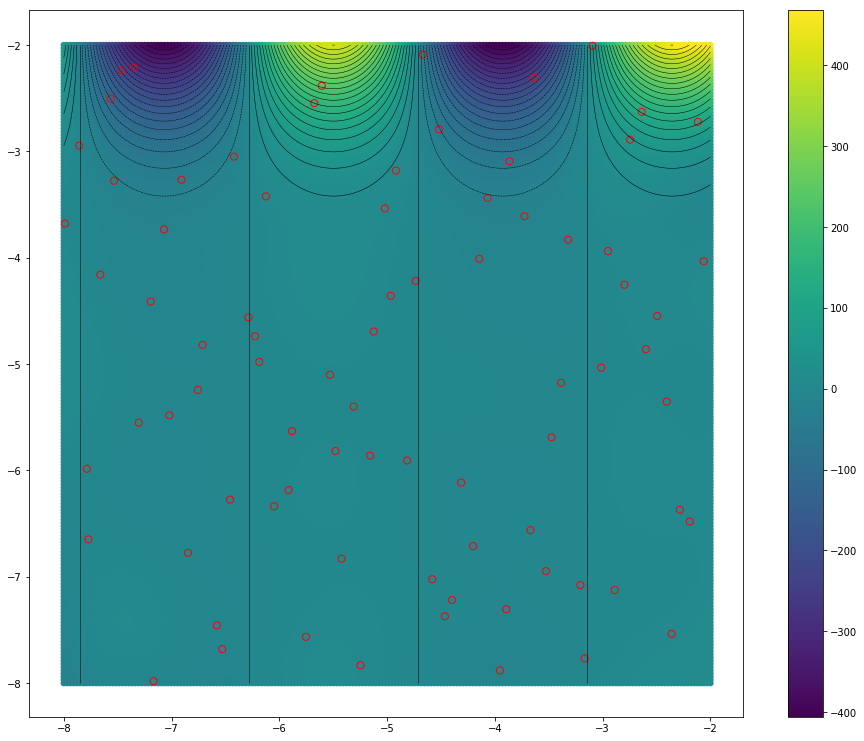

In [17]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))
np.set_printoptions(suppress=True)

print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.figure(figsize=(16,13))
style = dict(cmap='viridis', vmin=np.min(pred), vmax=np.max(pred))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=30, **style)
plt.colorbar()
plt.contour(x0pred,x1pred,500*np.sin(2*x0pred)*polyout(x1pred),levels=40,colors='k',linewidths=0.5)
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, **style,edgecolors='r')
plt.show()

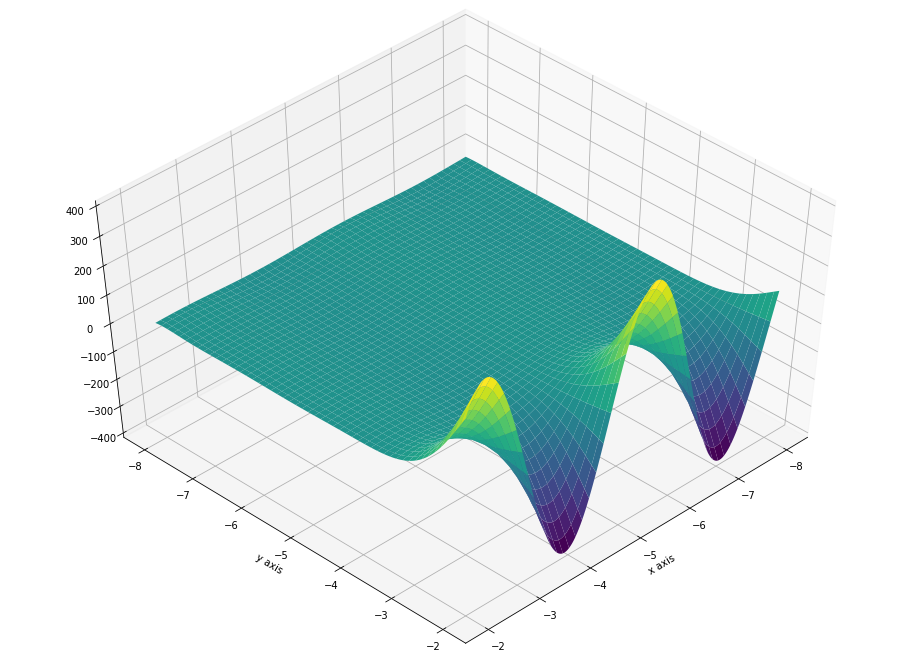

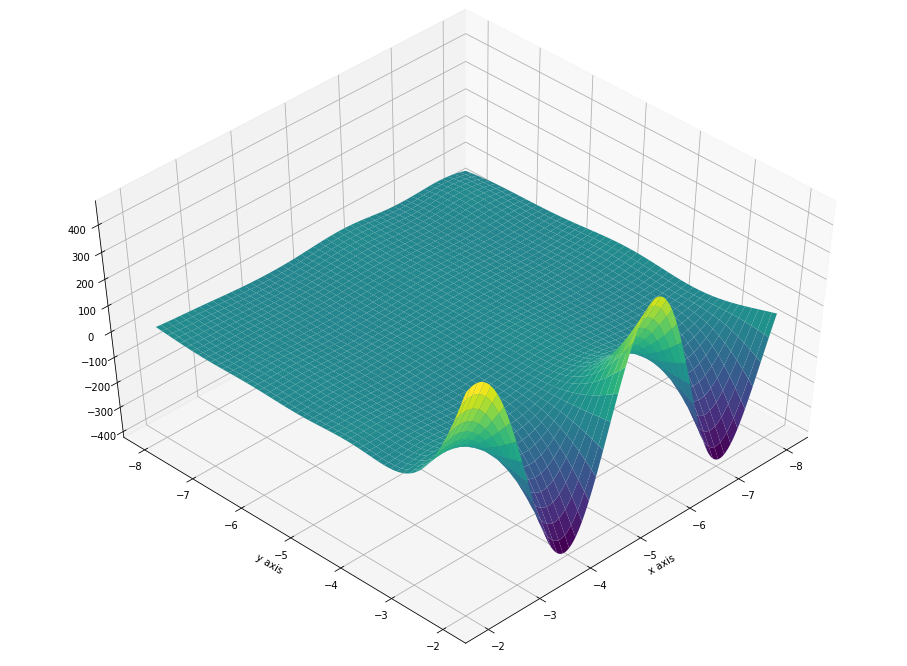

In [18]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.
surf = ax.plot_surface(x0pred,x1pred,np.sin(2*x0pred)*polyout(x1pred),cmap=cm.viridis)
ax.set_ylabel("y axis")
ax.set_xlabel("x axis")
ax.view_init(50, 45)
plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.
surfgp = ax.plot_surface(x0pred,x1pred,pred.reshape(200,200),cmap=cm.viridis)

ax.set_ylabel("y axis")
ax.set_xlabel("x axis")

ax.view_init(50, 45)
plt.show()